# Principle Component Anaysis on QPESUMS dataset

This notebook demonstrates how to perform [Principle Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) on the QPESUMS dataset.

The complete script for doing this job is in [`https://github.com/tingsyo/qpetw/blob/master/utils/dbz_ipca_with_filter.py`](https://github.com/tingsyo/qpetw/blob/master/utils/dbz_ipca_with_filter.py), and the following code cannot be executed without real data.

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Purpose: Perform Incremental PCA on QPESUMS data.
Description:
--input: directory that contains QPESUMS data as *.npy (6*275*162)
--output: the prefix of output files.
--model: the file contains the trained IncrementalPCA object.
--n_components: number of component to output.
"""
import os, csv, logging, argparse, pickle, h5py
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, IncrementalPCA
import joblib

''' Input processing '''
# Scan QPESUMS data in *.npy: 6*275*162 
def search_dbz(srcdir):
    import pandas as pd
    fileinfo = []
    for subdir, dirs, files in os.walk(srcdir, followlinks=True):
        for f in files:
            if f.endswith('.npy'):
                # Parse file name for time information
                furi = os.path.join(subdir, f)
                finfo = f.split('.')
                ftime = finfo[0]
                #logging.debug([furi] + finfo[1:3])
                fileinfo.append([furi, ftime])
    results = pd.DataFrame(fileinfo, columns=['furi', 'timestamp'])
    results = results.sort_values(by=['timestamp']).reset_index(drop=True)
    return(results)

# Read uris containing QPESUMS data in the format of 6*275*162 
def loadDBZ(flist):
    ''' Load a list a dbz files (in npy format) into one numpy array. '''
    xdata = []
    for f in flist:
        tmp = np.load(f)
        # Append new record
        if tmp is not None:            # Append the flattened data array if it is not None
            xdata.append(tmp.flatten())
    x = np.array(xdata, dtype=np.float32)
    return(x)

''' Project data into PCs '''
def transform_dbz(ipca, finfo):
    dbz = []
    # Loop through finfo
    for i in range(0,finfo.shape[0]):
        f = finfo.iloc[i,:]
        #logging.debug('Reading data from: ' + f['furi'])
        tmp = np.load(f['furi']).flatten()
        # Append new record
        if tmp is None:     # Copy the previous record if new record is empty
            logging.warning('File empty: '+f['furi'])
            dbz.append(np.zeros(ipca.n_components))
        else:
            tmp = tmp.reshape(1,len(tmp))
            tmp = ipca.transform(tmp).flatten()
            dbz.append(tmp)
    # Save changes of the storage file
    logging.debug('Data dimension after projection: ' + str(np.array(dbz).shape))
    return(dbz)

def writeToCsv(output, fname, header=None):
    # Overwrite the output file:
    with open(fname, 'w', newline='', encoding='utf-8-sig') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',quotechar='"', quoting=csv.QUOTE_ALL)
        if header is not None:
            writer.writerow(header)
        for r in output:
            writer.writerow(r)
    return(0)

#-----------------------------------------------------------------------
# Main function
#-----------------------------------------------------------------------
def main():
    # Configure Argument Parser
    parser = argparse.ArgumentParser(description='Retrieve DBZ data for further processing.')
    parser.add_argument('--input', '-i', help='the directory containing all the DBZ data.')
    parser.add_argument('--output', '-o', default='output', help='the output file.')
    parser.add_argument('--model', '-m', help='the trained IncrementalPCA object stored with joblib.')
    parser.add_argument('--n_components', '-n', default=20, type=int, help='number of component to output.')
    parser.add_argument('--log', '-l', default=None, help='the log file.')
    args = parser.parse_args()
    # Set up logging
    if not args.log is None:
        logging.basicConfig(level=logging.DEBUG, filename=args.log, filemode='w')
    else:
        logging.basicConfig(level=logging.DEBUG)
    # Scan files for reading
    finfo = search_dbz(args.input)
    logging.debug('Total data size: '+str(finfo.shape[0]))
    # Load Incremental PCA model
    logging.info("Load IncrementalPCA model from " + args.model)
    ipca = joblib.load(args.model)
    # Summarize results
    nc = ipca.n_components
    ev = ipca.explained_variance_
    evr = ipca.explained_variance_ratio_
    com = np.transpose(ipca.components_)
    logging.info("Model summary: ")
    logging.info("    Number of components: "+ str(nc))
    logging.info("    Explained variance ratio: "+ str(evr))
    # Transform the data with loaded model
    dbz_ipca = transform_dbz(ipca, finfo)
    # Append date and projections
    proj_header = ['timestamp'] + ['pc'+str(x+1) for x in range(nc)]
    newrecs = []
    for i in range(finfo.shape[0]):
        newrecs.append([finfo['timestamp'].iloc[i]] + list(dbz_ipca[i]))
    # Output
    writeToCsv(newrecs, args.output+".csv", header=proj_header)
    # done
    return(0)
    
#==========
# Script
#==========
if __name__=="__main__":
    main()


By specifying the data input, output, and other parameters, the script above will read in all qpesums data in the specified folder and output the fitted PCA model as well as a summary of explained variance. For example:


> `> python dbz_ipca_with_filter.py -i [path-to-qpesums-data] -o [output-prefix] -f [filter-file] -n 10`


The command above will perform a PCA with 10 pricipile components. However, if your qpesums data is not in the form of `6*275*162 numpy array`, you need to replace the data handling functions in the script.


## Some Results

In the [`Utility: Date Filter`](date_filters.ipynb) example, we create several filters:

- by Precipitation threshold

  -  1 mm/hr
  -  5 mm/hr
  - 10 mm/hr
  - 20 mm/hr
  - 40 mm/hr

- by Typhoon events

We will see some results of the PCA with the filters above and without any filter (all hourly QPESUMS data during 2013 ~ 2016).

### Explained Variance

First we look at the explained variance (as ratio) of the first 100 PCs. 

         full      fp01      fp05      fp10      fp20      fp40
pc1  0.300614  0.327142  0.360136  0.387328  0.418519  0.487474
pc2  0.091100  0.098519  0.091682  0.086359  0.081684  0.069022
pc3  0.046775  0.048692  0.049706  0.050334  0.049467  0.039509
pc4  0.037929  0.036050  0.034646  0.034029  0.034054  0.036698
pc5  0.022415  0.022696  0.022840  0.023463  0.021788  0.021848


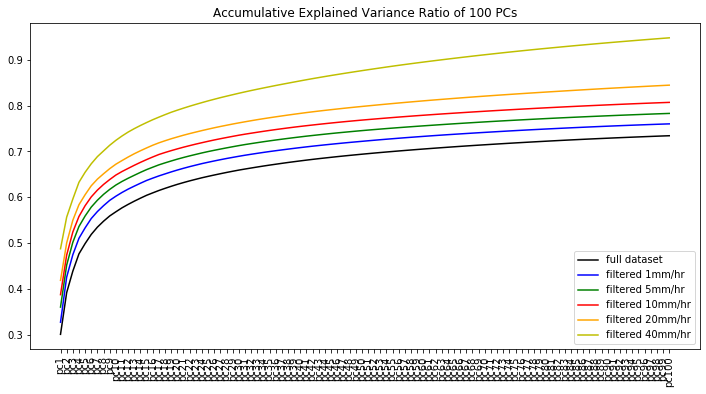

In [30]:
# Read processed data and show the explained variance ratio
import numpy as np
import pandas as pd

expvar = pd.read_csv('data/expvar.csv', index_col=0)
print(expvar.head())

# Making plot
plt.figure(figsize=(12,6))
plt.plot(np.cumsum(expvar.full), 'k', label='full dataset')
plt.plot(np.cumsum(expvar.fp01), 'b', label='filtered 1mm/hr')
plt.plot(np.cumsum(expvar.fp05), 'g', label='filtered 5mm/hr')
plt.plot(np.cumsum(expvar.fp10), 'r', label='filtered 10mm/hr')
plt.plot(np.cumsum(expvar.fp20), 'orange', label='filtered 20mm/hr')
plt.plot(np.cumsum(expvar.fp40), 'y', label='filtered 40mm/hr')
plt.xticks(rotation=90)
plt.title('Accumulative Explained Variance Ratio of 100 PCs')
plt.legend()
plt.show()

As shown in the figure above, when we applied filters to reduce the sample size, the explained variance ratio of the first few PCs increased. This should be reasonable since after filtering the data will be more homogeneous and then the variation will be reduced. Hence, fewer PCs can represent more variation in the dataset.


## PC1

We also want to know if there is difference between PCs derived from different datasets. First we recall a tool for illustrating the `6 x 275 x 162` numpy array. 

In [1]:
# Utility to plot a 6*275*162 numpy array
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from mpl_toolkits.basemap import Basemap

lat0 = 21.8875
lat1 = 25.3125
lon0 = 120.0
lon1 = 122.0125

lats = np.arange(21.8875, 25.3125, 0.0125)
lons = np.arange(120.0, 122.0125, 0.0125)

def plot_dbz_6maps(data):
    import matplotlib.pyplot as plt
    # Get data dimensions
    nl, ny, nx = data.shape
    print('Data dimensions: ' + str(nl) + ' layers of ' + str(ny) + ' x ' + str(nx))
    # Making plot
    for i in range(nl):
        ax = plt.subplot(2, nl/2, i+1)
        # create basemap
        m = Basemap(llcrnrlon=lon0, urcrnrlon=lon1, llcrnrlat=lat0, urcrnrlat=lat1, resolution='l')
        # draw coastlines on map.
        m.drawcoastlines()
        m.imshow(data[i], alpha=0.99, cmap='Greys')#, vmin=0., vmax=60.)
        m.colorbar()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()
    return(0)

### One snapshot of raw data

Data dimensions: 6 layers of 275 x 162


C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


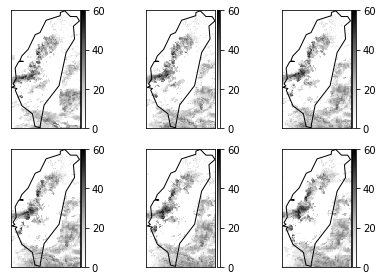

0

In [11]:
# 2014-06-13 06:00 No typhoon
d = np.load('../dbz_2014061316/2014061306.npy')
plot_dbz_6maps(d)

### Data Processing

The PCA model of 100 PCs is roughly 200MB on disk, so we fisrt take out only the first 5 PCs for faster processing.

### Full Dataset (34369 records)

Data dimensions: 6 layers of 275 x 162


C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


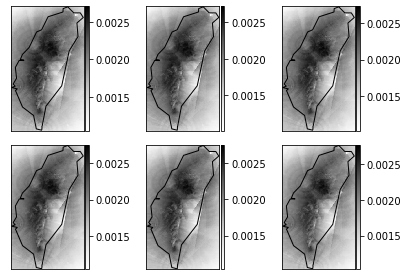

0

In [12]:
pc5 = np.load('data/full_pc5.npy', allow_pickle=True)
d=pc5[0,:].reshape(6, 275, 162)
plot_dbz_6maps(d)

### Data with Precipitation >= 1mm (11260 records)

Data dimensions: 6 layers of 275 x 162


C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


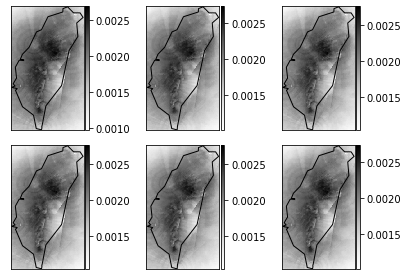

0

In [5]:
pc5 = np.load('data/fp01_pc5.npy', allow_pickle=True)
d=pc5[0,:].reshape(6, 275, 162)
plot_dbz_6maps(d)

### Data with Precipitation >= 5mm (4456 records)

Data dimensions: 6 layers of 275 x 162


C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


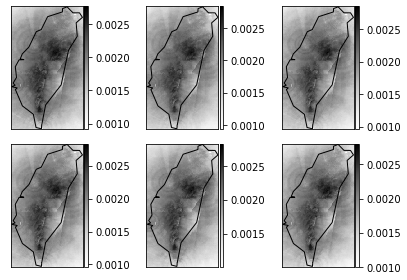

0

In [6]:
pc5 = np.load('data/fp05_pc5.npy', allow_pickle=True)
d=pc5[0,:].reshape(6, 275, 162)
plot_dbz_6maps(d)

### Data with Precipitation >= 10mm (2150 records)

Data dimensions: 6 layers of 275 x 162


C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


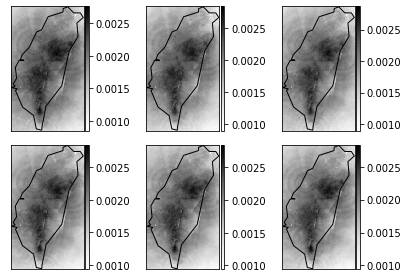

0

In [7]:
pc5 = np.load('data/fp10_pc5.npy', allow_pickle=True)
d=pc5[0,:].reshape(6, 275, 162)
plot_dbz_6maps(d)

### Data with Precipitation >= 20mm (858 records)

Data dimensions: 6 layers of 275 x 162


C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


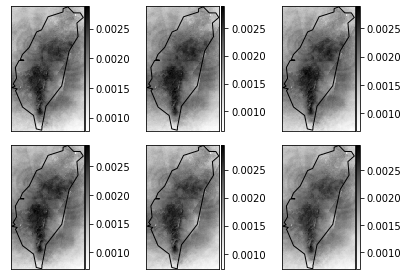

0

In [13]:
pc5 = np.load('data/fp20_pc5.npy', allow_pickle=True)
d=pc5[0,:].reshape(6, 275, 162)
plot_dbz_6maps(d)

### Data with Precipitation >= 40mm (236 records)

Data dimensions: 6 layers of 275 x 162


C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


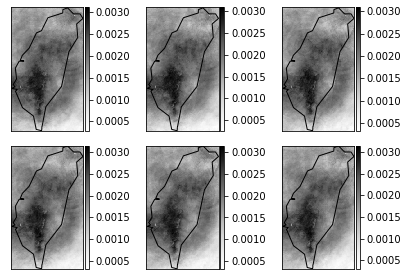

0

In [14]:
pc5 = np.load('data/fp40_pc5.npy', allow_pickle=True)
d=pc5[0,:].reshape(6, 275, 162)
plot_dbz_6maps(d)